In [81]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
df = pd.read_csv('kag_risk_factors_cervical_cancer.csv',na_values=["?"])

In [83]:
drops = [df.columns[i] for i in range(len(df.columns)) if df[df.columns[i]].isnull().sum() >= 150]
df = df.drop(drops,axis=1)

In [84]:
for i in range(len(df.columns)): 
    df[df.columns[i]] = df[df.columns[i]].fillna(df[df.columns[i]].mean()) 

In [85]:
X=pd.DataFrame(df[df.columns[0:30]]) 
y=pd.DataFrame(df[df.columns[30:34]])
Xb = X.copy()
yb = y.copy()

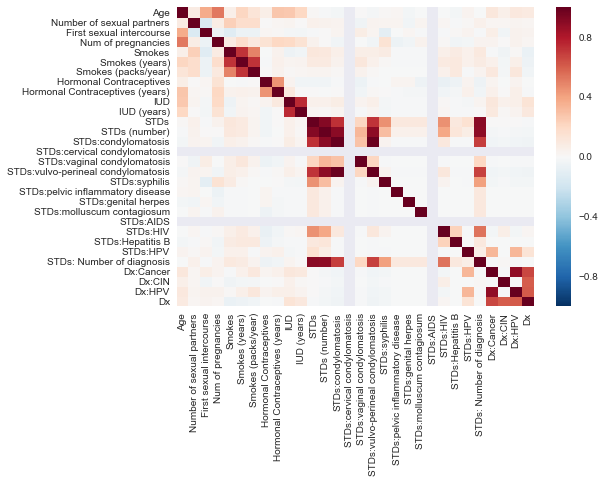

In [86]:
correlation = X.corr()
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values)
plt.show()
#correlation.style.background_gradient().set_precision(2)


In [87]:
#Function to delete (1 of) highly correlated feature pairs  
def del_high_correlation(df, th):
    ccol = set() 
    cmatx = df.corr()   
    for i in range(len(cmatx.columns)):
        for j in range(i):    
            if cmatx.iloc[i, j] >= th:
                col_to_del = cmatx.columns[i] 
                ccol.add(col_to_del)   
                if col_to_del in df.columns:
                    print(col_to_del)
                    del df[col_to_del] 
    df = pd.DataFrame(df)
    return(df)

In [88]:
X = del_high_correlation(X,0.7) #features to be removed

Smokes (years)
Smokes (packs/year)
IUD (years)
STDs (number)
STDs:condylomatosis
STDs:vulvo-perineal condylomatosis
STDs: Number of diagnosis
Dx:HPV


In [89]:
def feature_imp(scores,df):
    
    indices = sorted(range(len(scores)), key=lambda i: abs(scores[i]))[-len(df.columns):][::-1]
    ord_list = [df.columns[i] for i in indices]
    score_list = [100*scores[i] for i in indices]
    output = pd.DataFrame({'Feature':ord_list,'Score':score_list})
    output.index = np.arange(1,len(output)+1)
    
    return output
    

In [90]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0).fit(X, y)
scores = rf_model.feature_importances_ 
feat_imp = feature_imp(scores,X)

In [91]:
exclude = feat_imp['Feature'].tolist()[7:len(feat_imp)]
Xf = X.drop(exclude,axis=1)

In [92]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
x = scaler.fit_transform(Xf)
y = np.array(y)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=0)


In [93]:
X_train = X_train.reshape(X_train.shape[0], -1).T
X_test = X_test.reshape(X_test.shape[0], -1).T

print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

X_train shape: (7, 643)
X_test shape: (7, 215)


In [94]:
Y_train = Y_train.reshape(Y_train.shape[0], -1).T
Y_test = Y_test.reshape(Y_test.shape[0], -1).T

print ("y_train shape: " + str(Y_train.shape))
print ("y_test shape: " + str(Y_test.shape))

y_train shape: (4, 643)
y_test shape: (4, 215)


In [95]:
import tensorflow as tf
from tensorflow.python.framework import ops

def create_placeholders(n_x, n_y): 

    X = tf.placeholder(tf.float32,[n_x,None]) 
    Y = tf.placeholder(tf.float32,[n_y,None]) 

    return X, Y

In [96]:
def initialize_parameters(): 
   
    tf.set_random_seed(0) 
    W1 = tf.get_variable("W1",[10,7],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    b1 = tf.get_variable("b1",[10,1],initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2",[5,10],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    b2 = tf.get_variable("b2",[5,1],initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3",[4,5],initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3",[4,1],initializer = tf.zeros_initializer())
    
    
    parameters = {"W1": W1,"b1": b1,"W2": W2,"b2": b2,"W3": W3,"b3":b3}
    
    return parameters

In [97]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    
    return Z3

In [98]:
def compute_cost(Z3, Y): 
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
   
    return cost

In [99]:
def random_mini_batches(X, Y, mini_batch_size = 10, seed = 0):
  
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
     
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation]

    num_complete_minibatches = int(math.floor(m/mini_batch_size))
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [100]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.000001,
          num_epochs = 200, minibatch_size = 10, print_cost = True):
       
    ops.reset_default_graph()                         
    tf.set_random_seed(0)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                         
    n_y = Y_train.shape[0]                           
    costs = []                                        
     
    X, Y  = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

    
    with tf.Session() as sess:
        
        
        sess.run(init)
        
        
        for epoch in range(num_epochs):

            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        plt.clf()        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        parameters = sess.run(parameters)
        correct_prediction = tf.equal(tf.round(Z3), tf.round(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy: %", 100*accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy: %", 100 *accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters


Cost after epoch 0: 0.000000
Cost after epoch 100: 0.000000


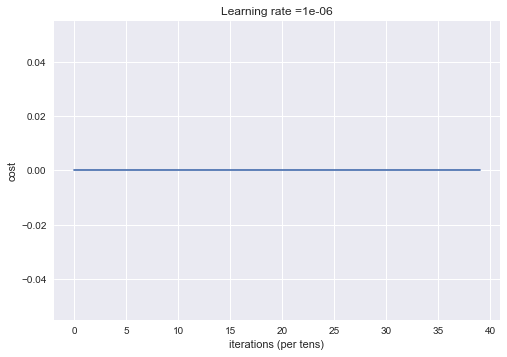

Train Accuracy: % 93.27371716499329
Test Accuracy: % 95.9302306175232


In [101]:
parameters = model(X_train, Y_train, X_test, Y_test)

 
 



Multilabel random forest and K-nearest neighbor base models are developed using all 30 original features. 
 
 

In [102]:
from sklearn.model_selection import train_test_split
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, random_state=0)

In [103]:
RF_clf = RandomForestClassifier(n_estimators=1000,oob_score=True,random_state=0).fit(Xb_train,yb_train)

print('Accuracy of RF classifier on training set: {:.2f} %'
     .format(100*RF_clf.score(Xb_train, yb_train)))
print('Accuracy of RF classifier on test set: {:.2f} %'
     .format(100*RF_clf.score(Xb_test, yb_test)))

Accuracy of RF classifier on training set: 99.69 %
Accuracy of RF classifier on test set: 89.30 %


In [104]:
leafs = [1,5,10,50,100,200]

for leaf in leafs:

    RF_clf2 = RandomForestClassifier(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =0,
                    max_features = "auto", min_samples_leaf = leaf).fit(Xb_train,yb_train)

    print('Accuracy of RF classifier on training set: {:.2f}'
         .format(RF_clf.score(Xb_train, yb_train)*100), "%", "OOB Score : " ,RF_clf.oob_score_)
    print('Accuracy of RF classifier on test set: {:.2f}'
         .format(RF_clf.score(Xb_test, yb_test)*100),"%", "OOB Score : " ,RF_clf.oob_score_)

Accuracy of RF classifier on training set: 99.69 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on test set: 89.30 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on training set: 99.69 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on test set: 89.30 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on training set: 99.69 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on test set: 89.30 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on training set: 99.69 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on test set: 89.30 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on training set: 99.69 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on test set: 89.30 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on training set: 99.69 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on test set: 89.30 % OOB Score :  0.9296267496111975


In [105]:
trees = [10,100,1000]
  
for tree in trees:

    RF_clf2 = RandomForestClassifier(n_estimators = tree, oob_score = True, n_jobs = -1,random_state =0,
                max_features = "auto").fit(Xb_train,yb_train)

    print('Accuracy of RF classifier on training set: {:.2f}'
        .format(RF_clf.score(Xb_train, yb_train)*100), "%", "OOB Score : " ,RF_clf.oob_score_)
    print('Accuracy of RF classifier on test set: {:.2f}'
        .format(RF_clf.score(Xb_test, yb_test)*100),"%" ,  "OOB Score : " , RF_clf.oob_score_)


/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Accuracy of RF classifier on training set: 99.69 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on test set: 89.30 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on training set: 99.69 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on test set: 89.30 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on training set: 99.69 % OOB Score :  0.9296267496111975
Accuracy of RF classifier on test set: 89.30 % OOB Score :  0.9296267496111975


In [106]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

for K in range(1,16):
    KNN_clf = KNeighborsClassifier(n_neighbors = K, weights='uniform', algorithm='auto').fit(Xb_train, yb_train) 
    y_pred_train = KNN_clf.predict(Xb_train)
    y_pred_test = KNN_clf.predict(Xb_test)
    
    #print ("Training Set Accuracy = ", "{0:.2f}".format(accuracy_score(yb_train,y_pred_train)*100),"% Neighbors = ",K)
    #print ("Test Set Accuracy = ", "{0:.2f}".format(accuracy_score(yb_test,y_pred_test)*100),"% Neighbors = ",K)
    #print("___________________________________________________")